# Latent Representation

based on the paper "Hard to beat baseline"

In [82]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from tqdm import tqdm

In [2]:
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

In [3]:
FASTA="/data/genomes/dna2vec_train/"
ff = glob.glob(f"{FASTA}*.fasta")
X = {}
for file in tqdm(ff):
    for record in SeqIO.parse(file, "fasta"):
        seq=str(record.seq)
        t = ["".join(seq[i:i+10]) for i in range(len(seq)-10)]
        tokens = list(filter(lambda x: set(x) == {'A', 'C', 'G', 'T'}, t))
        vectors = word_vectors[tokens]
        X[record.id]=np.mean(vectors, axis=0)

100%|██████████| 4715/4715 [19:38<00:00,  4.00it/s]  


In [4]:
len(X)

4715

In [9]:
df = pd.DataFrame().from_dict(X,orient="index")

In [71]:
pca          = pd.DataFrame(data=PCA(n_components=3).fit_transform(df.values),
                             columns=["pc1",'pc2',"pc3"])

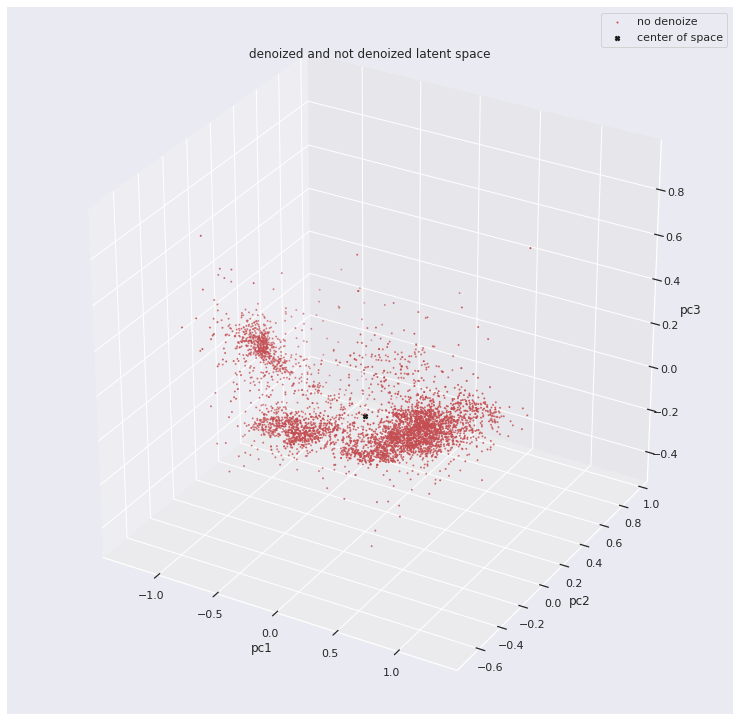

In [87]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(pca.loc[:,"pc1"],pca.loc[:,"pc2"],pca.loc[:,"pc3"], marker="o",s=1,color='r', label = "no denoize")
ax.scatter(0.,0.,0.,marker="X",color="k", label="center of space")
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set_title("denoized and not denoized latent space")
plt.legend()
plt.show()

### Denoising

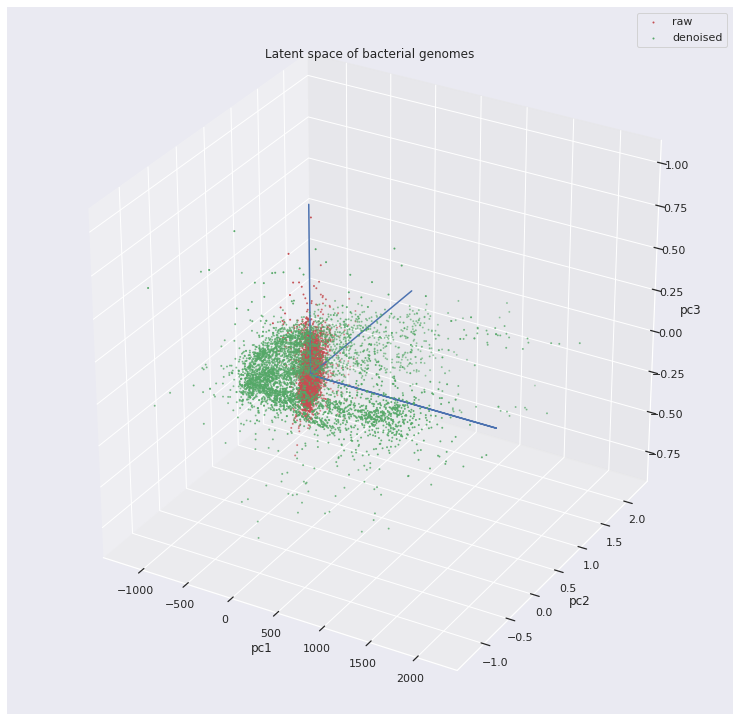

In [104]:
fc = PCA(n_components=1).fit_transform(df.values.T)
denoiser = np.dot(fc,fc.T)
X_dn = [x - np.dot(denoiser,x) for x in df.values]
pca_dn = pd.DataFrame(data=PCA(n_components=3).fit_transform(X_dn),
                             columns=["pc1",'pc2',"pc3"])

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(pca.loc[:,"pc1"],pca.loc[:,"pc2"],pca.loc[:,"pc3"], marker="o",s=1,color='r', label = "raw")
ax.scatter(pca_dn.loc[:,"pc1"],pca_dn.loc[:,"pc2"],pca_dn.loc[:,"pc3"], marker="o",s=1,color='g', label = "denoised")
ax.plot((0.,0.,0.),(2.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,2000.,0.),(0.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,0.,0.),(0.,0.,0.), (0.,0.,1.), color = "b")
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set_title("Latent space of bacterial genomes")
plt.legend()
plt.show()

http://127.0.0.1:3000/videos/?lesson=9&t=1786

### Autoencoder

In [105]:
from fastai import *

In [219]:
class KmlDataset(Dataset):
    """Kmer latent representation dataset"""
    def __init__(self, items):
        super().__init__()
        self.items = items.values() if isinstance(items, pd.DataFrame) else items
    def __len__(self):
        return len(items)
    def __getitem__(self, idx):
        return self.items[idx,:]
        

In [196]:
def wing(dims):
    layer_dims = list(zip(dims[:-1],dims[1:]))
    fcl = [nn.Linear(*x, bias=False) for x in layer_dims]
    relu = [nn.ReLU() for _ in range(len(fcl))]
    layers = np.asarray(list(zip(fcl, relu))).ravel()[:-1]                                
    return nn.Sequential(*layers)

In [197]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


In [217]:
def print_weights(nlayer):
    print(list(net.encoder.modules())[nlayer].weight)

In [210]:
class AutoEncoder (nn.Module):
    def __init__(self, encoder_dims, decoder_dims):
        super().__init__()
        self.encoder = wing(encoder_dims)
        self.decoder = wing(decoder_dims)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
        

In [211]:
encoder_dims = [100,50,3]
decoder_dims = [3,50,100]
net = AutoEncoder(encoder_dims,decoder_dims);net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=False)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=3, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=False)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=100, bias=False)
  )
)

In [212]:
net.encoder.apply(init_weights)
net.decoder.apply(init_weights)
net.opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [216]:
nepoch = 70
for epoch in range(nepoch):
    idata = iter(list(X.values()))
    print (f"Epoch {epoch}", end =" ")
    for i, vec in enumerate(idata):
        invec = tensor(vec)
        loss = F.mse_loss(model.forward(invec), invec)
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(f"loss:{loss:.5f}") 

Epoch 0 loss:0.00132
Epoch 1 loss:0.00132
Epoch 2 loss:0.00131
Epoch 3 loss:0.00131
Epoch 4 loss:0.00131
Epoch 5 loss:0.00131
Epoch 6 loss:0.00130
Epoch 7 loss:0.00130
Epoch 8 loss:0.00130
Epoch 9 loss:0.00130
Epoch 10 loss:0.00130
Epoch 11 loss:0.00130
Epoch 12 loss:0.00130
Epoch 13 loss:0.00129
Epoch 14 loss:0.00129
Epoch 15 loss:0.00129
Epoch 16 loss:0.00129
Epoch 17 loss:0.00129
Epoch 18 loss:0.00129
Epoch 19 loss:0.00129
Epoch 20 loss:0.00129
Epoch 21 loss:0.00129
Epoch 22 loss:0.00129
Epoch 23 loss:0.00129
Epoch 24 loss:0.00129
Epoch 25 loss:0.00129
Epoch 26 loss:0.00129
Epoch 27 loss:0.00129
Epoch 28 loss:0.00129
Epoch 29 loss:0.00129
Epoch 30 loss:0.00129
Epoch 31 loss:0.00129
Epoch 32 loss:0.00129
Epoch 33 loss:0.00129
Epoch 34 loss:0.00129
Epoch 35 loss:0.00129
Epoch 36 loss:0.00129
Epoch 37 loss:0.00129
Epoch 38 loss:0.00129
Epoch 39 loss:0.00129
Epoch 40 loss:0.00129
Epoch 41 loss:0.00129
Epoch 42 loss:0.00129
Epoch 43 loss:0.00129
Epoch 44 loss:0.00129
Epoch 45 loss:0.0012

### Fast.ai verision of training loop

In [ ]:
ds = KmlDataset(X)
